# Chess Move Prediction

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import chess
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
#from pandas_profiling import ProfileReport

## Functions

In [2]:
#Accepts a column of chess moves and sanitises it by replacing [ ] and , with nothing
def clean_moves(movesCol):
    array = []
    for col in movesCol:
        col = col.replace(',', '').replace("[",'').replace(']','').replace("'",'')
        array.append(col)
    return array

#Accepts a column and converts to string. Splits it based on spaces
def convert_string_split(col):
    col = col.astype(str)
    col = col.str.split()
    return col

In [24]:
df = pd.read_csv("games.csv")

In [25]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [26]:
df.shape

(20058, 16)

In [5]:
#Check types
df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

In [12]:
df["created_at"][108]

1503540000000.0

In [13]:
df["last_move_at"][108]

1503540000000.0

These two columns are the same. Therefore, useless.

In [4]:
#Printing a list of all column names
colList = df.columns.values.tolist()
print(colList)

['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status', 'winner', 'increment_code', 'white_id', 'white_rating', 'black_id', 'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply']


In [9]:
#Removing columns I do not need
df = df.drop(columns=["id",
                      "rated", 
                      "created_at",
                      "last_move_at",
                      "white_id",
                      "black_id",
                      "opening_eco",
                      "opening_name",
                      "opening_ply"], axis=1)

In [10]:
df.head()

,turns,victory_status,winner,increment_code,white_rating,black_rating,moves
0,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
1,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...
2,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
3,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...
4,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...


In [11]:
#Renaming Columns
df = df.rename(columns={"turns": "Turns",
                        "victory_status": "Outcome",
                        "winner": "Winner",
                        "increment_code": "Time_Control",
                       "white_rating": "White_Rating",
                       "black_rating": "Black_Rating",
                       "moves": "Moves"})

In [12]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves
0,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
1,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...
2,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
3,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...
4,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...


In [37]:
#Check types
df.dtypes

Turns            int64
Outcome         object
Winner          object
Time_Control    object
White_Rating     int64
Black_Rating     int64
Moves           object
dtype: object

It's a move prediction project so want Moves to be stored individually. <br>
I'll convert it all to a string and then split and store it as such

In [38]:
df["Moves"][0]

'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'

In [39]:
#Convert all of Moves column to a string format
df['Moves'] = df["Moves"].astype(str)

In [40]:
#Check type to see if it worked
type(df["Moves"][0])

str

In [41]:
#Split the string so I can have its moves individually accessible
df['Moves'] = df['Moves'].str.split()

In [42]:
df["Moves"][0]

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

In [43]:
#Check that a random move can be pulled
df["Moves"][0][3]

'c6'

In [48]:
#White Moves
print(df["Moves"][0][::2]) #Starts at the first element and goes in steps of 2. Every odd move is white's

['d4', 'c4', 'cxd5', 'dxe6', 'Nf3', 'Nc3', 'Bf4']


In [49]:
#Black Moves
print(df["Moves"][0][1::2]) #Starts at the 2nd element (zero is first) and skips. Every even move is black's

['d5', 'c6', 'e6', 'fxe6', 'Bb4+', 'Ba5']


In [46]:
#For loop that goes through all of Moves and takes the even/odd move and stores it separately.
#Then creates two new columns for White's and Black's Moves
white = []
black = []
for x in df["Moves"]:
    white.append(x[::2])
    black.append(x[1::2])
df["White_Moves"] = white
df["Black_Moves"] = black

In [50]:
#Check is worked
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves
0,13,outoftime,white,15+2,1500,1191,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]"
1,16,resign,black,5+10,1322,1261,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]"
2,61,mate,white,5+10,1496,1500,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa..."
3,61,mate,white,20+0,1439,1454,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2..."
4,95,mate,white,30+3,1523,1469,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx..."


In [51]:
df.to_csv('chess.csv', index=False)

In [22]:
df = pd.read_csv("chess.csv")

In [23]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves
0,13,outoftime,white,15+2,1500,1191,"['d4', 'd5', 'c4', 'c6', 'cxd5', 'e6', 'dxe6',...","['d4', 'c4', 'cxd5', 'dxe6', 'Nf3', 'Nc3', 'Bf4']","['d5', 'c6', 'e6', 'fxe6', 'Bb4+', 'Ba5']"
1,16,resign,black,5+10,1322,1261,"['d4', 'Nc6', 'e4', 'e5', 'f4', 'f6', 'dxe5', ...","['d4', 'e4', 'f4', 'dxe5', 'fxe5', 'Qd4', 'Qe5...","['Nc6', 'e5', 'f6', 'fxe5', 'Nxe5', 'Nc6', 'Nx..."
2,61,mate,white,5+10,1496,1500,"['e4', 'e5', 'd3', 'd6', 'Be3', 'c6', 'Be2', '...","['e4', 'd3', 'Be3', 'Be2', 'Nd2', 'a4', 'axb5'...","['e5', 'd6', 'c6', 'b5', 'a5', 'c5', 'Nc6', 'R..."
3,61,mate,white,20+0,1439,1454,"['d4', 'd5', 'Nf3', 'Bf5', 'Nc3', 'Nf6', 'Bf4'...","['d4', 'Nf3', 'Nc3', 'Bf4', 'e3', 'Be2', 'O-O'...","['d5', 'Bf5', 'Nf6', 'Ng4', 'Nc6', 'Qd7', 'O-O..."
4,95,mate,white,30+3,1523,1469,"['e4', 'e5', 'Nf3', 'd6', 'd4', 'Nc6', 'd5', '...","['e4', 'Nf3', 'd4', 'd5', 'a3', 'Nc3', 'b4', '...","['e5', 'd6', 'Nc6', 'Nb4', 'Na6', 'Be7', 'Nf6'..."


To do for next day: <br>
    Basic EDA <br>
    See some stats

In [24]:
df["Moves"][0][8]

'd'

Not stored correctly so need to fix it to continue

In [25]:
#Calls clean_moves function to get rid of the 'noise' in the strings
df["Moves"] = clean_moves(df["Moves"])
df["White_Moves"] = clean_moves(df["White_Moves"])
df["Black_Moves"] = clean_moves(df["Black_Moves"])

In [26]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves
0,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,d4 c4 cxd5 dxe6 Nf3 Nc3 Bf4,d5 c6 e6 fxe6 Bb4+ Ba5
1,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,d4 e4 f4 dxe5 fxe5 Qd4 Qe5+ c4,Nc6 e5 f6 fxe5 Nxe5 Nc6 Nxe5 Bb4+
2,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,e4 d3 Be3 Be2 Nd2 a4 axb5 bxc6 Nc4 c3 Nxa3 Rxa...,e5 d6 c6 b5 a5 c5 Nc6 Ra6 a4 a3 Rxa3 c4 d5 Qxd...
3,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,d4 Nf3 Nc3 Bf4 e3 Be2 O-O Nb5 Rc1 Ra1 Nxa7+ Nb...,d5 Bf5 Nf6 Ng4 Nc6 Qd7 O-O-O Nb4 Nxa2 Nb4 Kb8 ...
4,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,e4 Nf3 d4 d5 a3 Nc3 b4 Bg5 b5 Bxf6 Bd3 O-O Qxd...,e5 d6 Nc6 Nb4 Na6 Be7 Nf6 O-O Nc5 Bxf6 Qd7 Nxd...


In [27]:
#Calls function to convert string and split string so that they are moves
df["Moves"] = convert_string_split(df["Moves"])
df["White_Moves"] = convert_string_split(df["White_Moves"])
df["Black_Moves"] = convert_string_split(df["Black_Moves"])

In [28]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves
0,13,outoftime,white,15+2,1500,1191,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]"
1,16,resign,black,5+10,1322,1261,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]"
2,61,mate,white,5+10,1496,1500,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa..."
3,61,mate,white,20+0,1439,1454,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2..."
4,95,mate,white,30+3,1523,1469,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx..."


In [29]:
df["Moves"][0][4]

'cxd5'

Back to normal. Can continue now

To do: <br>
    Write that as a function

In [53]:
#prof = ProfileReport(df)
#prof.to_file(output_file='output.html')

Need to create a next moves list. This will be used as a target variable <br>
I am going to take the moves list and shift it back one to do accomplish this

In [85]:
movesList = df["Moves"].str.split()

In [86]:
nextMovesList = movesList.shift(-1)

In [87]:
print(nextMovesList)

0        [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
1        [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
2        [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
3        [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
4        [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
                               ...                        
20053    [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
20054    [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
20055    [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
20056    [d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ...
20057                                                  NaN
Name: Moves, Length: 20058, dtype: object


In [88]:
df["Next_Moves"] = nextMovesList

In [89]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Next_Moves
0,13,outoftime,white,15+2,1500,1191,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,d4 Bf4 e3 c3 Nf3 Nbd2 Bd3 e4 e5 Nxe4 Bxe4 Bxa8...,d5 Na6 e6 Nf6 Bd7 b5 Qc8 b4 Ne4 dxe4 bxc3 Qxa8...,"[d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ..."
1,16,resign,black,5+10,1322,1261,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,d4 Bf4 e3 c3 Nf3 Nbd2 Bd3 e4 e5 Nxe4 Bxe4 Bxa8...,d5 Na6 e6 Nf6 Bd7 b5 Qc8 b4 Ne4 dxe4 bxc3 Qxa8...,"[d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ..."
2,61,mate,white,5+10,1496,1500,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,d4 Bf4 e3 c3 Nf3 Nbd2 Bd3 e4 e5 Nxe4 Bxe4 Bxa8...,d5 Na6 e6 Nf6 Bd7 b5 Qc8 b4 Ne4 dxe4 bxc3 Qxa8...,"[d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ..."
3,61,mate,white,20+0,1439,1454,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,d4 Bf4 e3 c3 Nf3 Nbd2 Bd3 e4 e5 Nxe4 Bxe4 Bxa8...,d5 Na6 e6 Nf6 Bd7 b5 Qc8 b4 Ne4 dxe4 bxc3 Qxa8...,"[d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ..."
4,95,mate,white,30+3,1523,1469,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,d4 Bf4 e3 c3 Nf3 Nbd2 Bd3 e4 e5 Nxe4 Bxe4 Bxa8...,d5 Na6 e6 Nf6 Bd7 b5 Qc8 b4 Ne4 dxe4 bxc3 Qxa8...,"[d4, d5, Bf4, Na6, e3, e6, c3, Nf6, Nf3, Bd7, ..."


In [30]:
print(pd.unique(df["Outcome"]))

['outoftime' 'resign' 'mate' 'draw']


In [31]:
print(pd.unique(df["Winner"]))

['white' 'black' 'draw']


In [32]:
print(pd.unique(df["Time_Control"]))

['15+2' '5+10' '20+0' '30+3' '10+0' '15+30' '15+0' '20+60' '5+40' '8+0'
 '15+15' '15+16' '11+0' '30+60' '15+5' '10+10' '15+3' '18+0' '30+30'
 '20+25' '5+5' '30+0' '40+40' '16+0' '6+10' '8+10' '8+12' '7+12' '15+10'
 '20+5' '20+10' '45+0' '5+8' '30+2' '25+0' '10+2' '7+2' '25+25' '7+8'
 '6+6' '10+4' '12+0' '15+1' '2+10' '9+0' '10+9' '6+7' '30+10' '30+15'
 '10+3' '45+30' '9+2' '7+3' '6+5' '25+5' '5+7' '8+2' '20+8' '30+5' '25+15'
 '15+7' '8+8' '5+9' '16+7' '10+7' '7+5' '40+20' '10+5' '11+5' '10+15'
 '180+0' '17+5' '8+5' '3+8' '60+120' '90+120' '15+8' '9+1' '9+3' '2+15'
 '10+1' '5+12' '60+10' '5+60' '8+15' '30+25' '12+1' '14+0' '60+20' '10+8'
 '20+3' '14+12' '7+7' '60+0' '45+45' '4+15' '5+6' '180+180' '8+3' '4+6'
 '10+25' '3+10' '7+4' '6+3' '5+15' '45+15' '15+20' '6+8' '6+9' '14+8'
 '6+4' '15+4' '9+20' '20+15' '20+2' '9+10' '8+7' '13+1' '150+180' '3+12'
 '7+10' '10+60' '5+30' '20+30' '14+10' '25+10' '8+1' '19+0' '9+12' '20+1'
 '0+25' '0+15' '15+6' '8+6' '10+6' '25+8' '15+14' '20+20' '13+10' 

... Time Control is a bit of a mess

## Preparation for Machine Learning

Interger encoding for Outcome <br>
0 will be "outoftime", 1 for "resign", 2 for "draw", 3 for "mate" 

In [33]:
outcome = df["Outcome"]
array = []
for x in outcome:
    if x == "outoftime":
        x = 0
    elif x == "resign":
        x = 1
    elif x == "draw":
        x = 2
    elif x == "mate":
        x = 3
    array.append(x)
outcome = array

df["Outcome"] = outcome

Going to use one integer encoding for the Winner column. Black wins will be 0, White wins will be 1, Draw will be 2.

In [34]:
winner = df["Winner"]
array = []
for x in winner:
    if x == "white":
        x = 1
    elif x == "black":
        x = 0
    elif x == "draw":
        x = 2
    array.append(x)
winner = array

df["Winner"] = winner

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [36]:
#Convert to numpy array as it
whiteRating = df[["White_Rating"]]
blackRating = df[["Black_Rating"]]

#Initialise Scaler
scaler = MinMaxScaler()

#Transform Data
whiteScaled = scaler.fit_transform(whiteRating)
blackScaled = scaler.fit_transform(blackRating)

#Slot data back into dataframe
df["White_Rating"] = whiteScaled
df["Black_Rating"] = blackScaled

In [37]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]"
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]"
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa..."
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2..."
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx..."


In [38]:
df.to_csv('prep.csv', index=False)

Using a standard scaler. Better preserves the relationship for Elo rating

In [21]:
#Take white/black's rating
whiteRating = df["White_Rating"]
whiteRating = whiteRating.reshape(-1, 1)
blackRating = df["Black_Rating"]
blackRating - blackRating.reshape(-1, 1)

#Scale them
scale= StandardScaler()
scaledWData = scale.fit_transform(whiteRating)
scaledBData = scale.fit_transform(blackRating)

#Place them in dataframe
df["White_Rating"] = scaledWData
df["Black_Rating"] = scaledBData

AttributeError: 'Series' object has no attribute 'reshape'

In [39]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]"
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]"
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa..."
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2..."
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx..."


In [90]:
df["Moves"][0]

'd4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3 Qc8 e4 b4 e5 Ne4 Nxe4 dxe4 Bxe4 bxc3 Bxa8 Qxa8 bxc3 Ba3 Rb1 c5 Qd3 O-O Qxa6 Bc6 Qxa3 Bxf3 gxf3 Qxf3 Qxa7 Qxh1+ Ke2 Qxb1 Qxc5 Qc2+ Ke3 Qxa2 Qb4 h6 c4 g5 Bg3 Qa8 c5 Rb8 Qc3 f5 f4 Qe4+ Kd2 Qg2+ Kd3 gxf4 Bxf4 Qf3+ Kc4 Qxf4 c6 Qf1+ Kc5 Rb1 Qg3+ Kf7 c7 Rc1+ Kd6 Qa6+ Kd7 Qb5+ Kd8 Qe8#'

In [91]:
df["Next_Moves"][0]

['d4',
 'd5',
 'Bf4',
 'Na6',
 'e3',
 'e6',
 'c3',
 'Nf6',
 'Nf3',
 'Bd7',
 'Nbd2',
 'b5',
 'Bd3',
 'Qc8',
 'e4',
 'b4',
 'e5',
 'Ne4',
 'Nxe4',
 'dxe4',
 'Bxe4',
 'bxc3',
 'Bxa8',
 'Qxa8',
 'bxc3',
 'Ba3',
 'Rb1',
 'c5',
 'Qd3',
 'O-O',
 'Qxa6',
 'Bc6',
 'Qxa3',
 'Bxf3',
 'gxf3',
 'Qxf3',
 'Qxa7',
 'Qxh1+',
 'Ke2',
 'Qxb1',
 'Qxc5',
 'Qc2+',
 'Ke3',
 'Qxa2',
 'Qb4',
 'h6',
 'c4',
 'g5',
 'Bg3',
 'Qa8',
 'c5',
 'Rb8',
 'Qc3',
 'f5',
 'f4',
 'Qe4+',
 'Kd2',
 'Qg2+',
 'Kd3',
 'gxf4',
 'Bxf4',
 'Qf3+',
 'Kc4',
 'Qxf4',
 'c6',
 'Qf1+',
 'Kc5',
 'Rb1',
 'Qg3+',
 'Kf7',
 'c7',
 'Rc1+',
 'Kd6',
 'Qa6+',
 'Kd7',
 'Qb5+',
 'Kd8',
 'Qe8#']

In [3]:
df = pd.read_csv("prep.csv")

In [4]:
df["Moves"] = clean_moves(df["Moves"])
df["White_Moves"] = clean_moves(df["White_Moves"])
df["Black_Moves"] = clean_moves(df["Black_Moves"])

df["Moves"] = convert_string_split(df["Moves"])
df["White_Moves"] = convert_string_split(df["White_Moves"])
df["Black_Moves"] = convert_string_split(df["Black_Moves"])

In [5]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",['Bf4']
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",['Bb4+']
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",['Bd1#']
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",['Qxg7#']
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",['Rh7#']


In [8]:
#Testing slicing for last element
df["Moves"][0][-1:]

['Bf4']

In [9]:
df["Moves"][1][-1:]

['Bb4+']

In [47]:
final = []
for x in df["Moves"]:
    final.append(x[-1:])
df["Final_Move"] = final

In [48]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",[Bf4]
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",[Bb4+]
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",[Bd1#]
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",[Qxg7#]
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",[Rh7#]


In [49]:
df.to_csv('prep.csv', index=False)

In [4]:
df = pd.read_csv("prep.csv")

In [3]:
df["Moves"] = clean_moves(df["Moves"])
df["White_Moves"] = clean_moves(df["White_Moves"])
df["Black_Moves"] = clean_moves(df["Black_Moves"])
df["Final_Move"] = clean_moves(df["Final_Move"])

df["Moves"] = convert_string_split(df["Moves"])
df["White_Moves"] = convert_string_split(df["White_Moves"])
df["Black_Moves"] = convert_string_split(df["Black_Moves"])
df["Final_Move"] = convert_string_split(df["Final_Move"])

NameError: name 'df' is not defined

In [13]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",[Bf4]
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",[Bb4+]
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",[Bd1#]
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",[Qxg7#]
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",[Rh7#]


In [14]:
df["X_Moves"] = df["Moves"][:-1]

In [15]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,X_Moves
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",[Bf4],"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb..."
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",[Bb4+],"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx..."
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",[Bd1#],"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4..."
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",[Qxg7#],"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6..."
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",[Rh7#],"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N..."


In [8]:
df = df.iloc[:2000]

In [8]:
X[0]

'd4'

In [9]:
board = chess.Board()

In [10]:
moves = X[0]

In [11]:
for move in moves:
    board.push_san(move)

In [12]:
print(board)

r n b q k . n r
p p . . . . p p
. . p . p . . .
b . . . . . . .
. . . P . . . .
. . N . . N . .
P P . . P P P P
R . B Q K B . R


In [13]:
board.legal_moves

<LegalMoveGenerator at 0x1d55919b370 (Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, Qb3, Qd2, Qc2, Bh6, Bg5, Bf4, Be3, Bd2, Rb1, d5, h3, g3, e3, b3, a3, h4, g4, e4, b4, a4)>

In [15]:
legalMoves = str(board.legal_moves)

In [16]:
legalMoves

'<LegalMoveGenerator at 0x1d55919b0d0 (Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, Qb3, Qd2, Qc2, Bh6, Bg5, Bf4, Be3, Bd2, Rb1, d5, h3, g3, e3, b3, a3, h4, g4, e4, b4, a4)>'

In [29]:
import re
regEx = re.search(r"\((.*?)\)", legalMoves)

In [30]:
regEx[0]

'(Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, Qb3, Qd2, Qc2, Bh6, Bg5, Bf4, Be3, Bd2, Rb1, d5, h3, g3, e3, b3, a3, h4, g4, e4, b4, a4)'

In [31]:
legalMoves = str(regEx[0])

In [32]:
legalMoves = legalMoves.replace("(","").replace(")","")

In [33]:
legalMoves

'Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, Qb3, Qd2, Qc2, Bh6, Bg5, Bf4, Be3, Bd2, Rb1, d5, h3, g3, e3, b3, a3, h4, g4, e4, b4, a4'

In [34]:
legalMoves = legalMoves.split(",")

In [37]:
legalMoves[0]

'Ng5'

In [36]:
df["Moves"][0]

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

In [49]:
legal = []
for x in X:
    board = chess.Board() #Initialises Board/resets each loop
    moves = x #renaming to follow code easier
    for move in moves:
        board.push_san(move) #pushes each piece. Need for loop as method only pushes one move
    legalMoves = str(board.legal_moves) #gets every legal move in string format
    regEx = re.search(r"\((.*?)\)", legalMoves) #Regular Expression to get everything inside ()
    legalMoves = str(regEx[0]) 
    legalMoves = legalMoves.replace("(","").replace(")","").split(",") #Clean the output
    legal.append(legalMoves)
df["Legal_Moves"] = legal #make new column

In [50]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,Legal_Moves
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",[Bf4],"[Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4..."
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",[Bb4+],"[Ne7, Nh6, Nf6, Be7, Bd6, Bc5, Bb4+, Ba..."
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",[Bd1#],"[Rh8, Rh7, Rg6, Rf6, Re6, Rd6, Rh5, Rh4..."
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",[Qxg7#],"[Ra8, Rxg7, Rf7, Re7, Rd7, Rc7, Rb7, Ra..."
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",[Rh7#],"[Qh8+, Qf8+, Qe8, Qd8, Qc8, Qb8, Qa8, Q..."


In [51]:
df["Legal_Moves"][0]

['Ng5',
 ' Ne5',
 ' Nh4',
 ' Nd2',
 ' Ng1',
 ' Rg1',
 ' Kd2',
 ' Qa4',
 ' Qd3',
 ' Qb3',
 ' Qd2',
 ' Qc2',
 ' Bh6',
 ' Bg5',
 ' Bf4',
 ' Be3',
 ' Bd2',
 ' Rb1',
 ' d5',
 ' h3',
 ' g3',
 ' e3',
 ' b3',
 ' a3',
 ' h4',
 ' g4',
 ' e4',
 ' b4',
 ' a4']

In [ ]:
df.to_csv('legalMoves.csv', index=False)

In [4]:
df = pd.read_csv("legalMoves.csv")

In [5]:
df["Moves"] = clean_moves(df["Moves"])
df["White_Moves"] = clean_moves(df["White_Moves"])
df["Black_Moves"] = clean_moves(df["Black_Moves"])
df["Legal_Moves"] = clean_moves(df["Legal_Moves"])

df["Moves"] = convert_string_split(df["Moves"])
df["White_Moves"] = convert_string_split(df["White_Moves"])
df["Black_Moves"] = convert_string_split(df["Black_Moves"])
df["Legal_Moves"] = convert_string_split(df["Legal_Moves"])

# SVM

In [6]:
#Features
X = df["Moves"].apply(lambda x: x[:-1]) #Moves all but last one
              
#Target
y = df["Moves"].apply(lambda x: x[-1]) #Last Move

In [7]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,Legal_Moves,Elo_Diff,Bitboard
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",['Bf4'],"[Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, ...",309,1101111111000011000101000000000100001000001001...
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",['Bb4+'],"[Ne7, Nh6, Nf6, Be7, Bd6, Bc5, Bb4+, Ba3, Kf7,...",61,1111110111001111000000000001000000010100000000...
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",['Bd1#'],"[Rh8, Rh7, Rg6, Rf6, Re6, Rd6, Rh5, Rh4, Rh3, ...",4,1000001000010000010000010001010000010011100010...
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",['Qxg7#'],"[Ra8, Rxg7, Rf7, Re7, Rd7, Rc7, Rb7, Ra6, Ra5,...",15,1000000011000001111001000101100000000000010100...
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",['Rh7#'],"[Qh8+, Qf8+, Qe8, Qd8, Qc8, Qb8, Qa8, Qh7+, Qg...",54,1000000001000001000000000000000000100010010000...


In [8]:
X[5][0]

'e4'

In [9]:
y[0]

'Bf4'

In [17]:
df = df[["White_Rating"]] > 0.7

Using MultiLabelBinarizer to transform iterable of iterables. My moves within moves <br>
Transforms into binary array

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

# Transform the moves using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
X = pd.DataFrame(mlb.fit_transform(X), columns=mlb.classes_)

LabelEncoder transforms unique categorical values into numerical labels

In [19]:
X

,B6e7,Ba1,Ba2,Ba2+,Ba3,Ba3+,Ba4,Ba4+,Ba5,Ba5+,...,hxg4,hxg4+,hxg5,hxg5+,hxg6,hxg6+,hxg7,hxg7+,hxg8=Q,hxg8=Q+
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
20054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

In [12]:
y

array([ 102,   21,   54, ..., 1019, 1351,  903])

In [9]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) # 70%/30% training/testing

In [23]:
X_train.shape

(14040, 3784)

In [24]:
y_train.shape

(14040,)

In [15]:
from sklearn import svm
from sklearn.svm import SVC

In [12]:
#Create and fit SVM classifier
clf = SVC(kernel='linear', C=1.0, random_state=23)
clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=23)

In [13]:
#Prediction for testing set
predictions = clf.predict(X_test)

In [11]:
from sklearn.metrics import classification_report

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.20      0.33      0.25         3
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.07      0.14      0.10         7
          21       0.00      0.00      0.00         4
          22       0.10      0.17      0.12        12
          23       0.00      0.00      0.00         1
          24       0.17      0.33      0.22         3
          25       0.00    

C:\Users\yamyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yamyu\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [14]:
from sklearn.metrics import accuracy_score

In [16]:
#predictionLabels = labelEncoder.inverse_transform(predictions)

#Print Accuracy Score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.09504818876703224


In [27]:
#Print Precision Score
print("precision", metrics.precision_score(y_test, predictions, average="micro"))

precision 0.09504818876703224


In [22]:
#Print Recall
print("recall", metrics.recall_score(y_test, predictions, average="micro"))

recall 0.09504818876703224


In [30]:
# confusion matrix
confusion_matrix(y_true=y_test, y_pred=predictions)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\yamyu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.012 total time=15.4min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.013 total time=15.8min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.013 total time=15.8min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.013 total time=15.9min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.012 total time=15.9min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.015 total time=15.1min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.017 total time=16.1min


Taking way too long. Tried Google Colab and even that wasn't enough

# Decision Trees

In [15]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth = 3, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [31]:
y_pred = classifier.predict(X_test)

In [32]:
from sklearn import metrics                           # Import scikit-learn metrics module for accuracy calculation
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.018112329677633765


[Text(0.5, 0.875, 'X[1218] <= 0.5\ngini = 0.998\nsamples = 14040\nvalue = [1, 2, 6 ... 5, 2, 1]'),
 Text(0.25, 0.625, 'X[1459] <= 0.5\ngini = 0.997\nsamples = 3453\nvalue = [0, 0, 0 ... 1, 1, 0]'),
 Text(0.125, 0.375, 'X[917] <= 0.5\ngini = 0.997\nsamples = 2994\nvalue = [0, 0, 0 ... 0, 1, 0]'),
 Text(0.0625, 0.125, 'gini = 0.991\nsamples = 920\nvalue = [0, 0, 0 ... 0, 1, 0]'),
 Text(0.1875, 0.125, 'gini = 0.998\nsamples = 2074\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.375, 0.375, 'X[3542] <= 0.5\ngini = 0.984\nsamples = 459\nvalue = [0, 0, 0 ... 1, 0, 0]'),
 Text(0.3125, 0.125, 'gini = 0.945\nsamples = 183\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.4375, 0.125, 'gini = 0.993\nsamples = 276\nvalue = [0, 0, 0 ... 1, 0, 0]'),
 Text(0.75, 0.625, 'X[349] <= 0.5\ngini = 0.998\nsamples = 10587\nvalue = [1, 2, 6 ... 4, 1, 1]'),
 Text(0.625, 0.375, 'X[358] <= 0.5\ngini = 0.998\nsamples = 8921\nvalue = [1, 1, 6 ... 3, 1, 1]'),
 Text(0.5625, 0.125, 'gini = 0.999\nsamples = 7709\nvalue = [1, 1, 4 

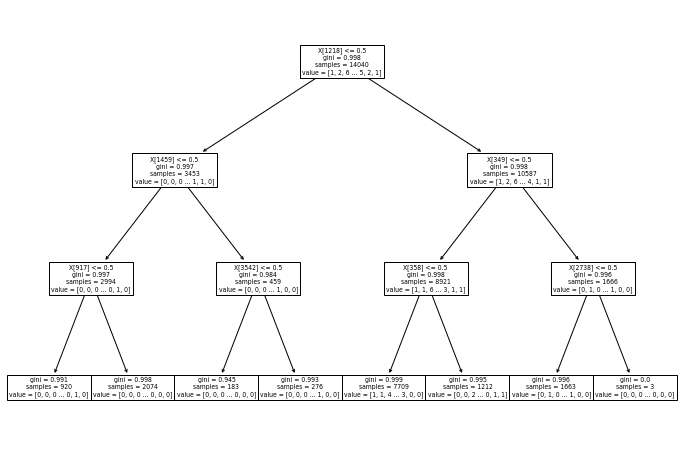

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(classifier.fit(X_train, y_train)) 

## Adding features

In [10]:
legal = df["Legal_Moves"]
legal = pd.DataFrame(mlb.fit_transform(legal), columns=mlb.classes_)

In [15]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,Legal_Moves,Elo_Diff,Bitboard
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",['Bf4'],"[Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, ...",309,1101111111000011000101000000000100001000001001...
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",['Bb4+'],"[Ne7, Nh6, Nf6, Be7, Bd6, Bc5, Bb4+, Ba3, Kf7,...",61,1111110111001111000000000001000000010100000000...
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",['Bd1#'],"[Rh8, Rh7, Rg6, Rf6, Re6, Rd6, Rh5, Rh4, Rh3, ...",4,1000001000010000010000010001010000010011100010...
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",['Qxg7#'],"[Ra8, Rxg7, Rf7, Re7, Rd7, Rc7, Rb7, Ra6, Ra5,...",15,1000000011000001111001000101100000000000010100...
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",['Rh7#'],"[Qh8+, Qf8+, Qe8, Qd8, Qc8, Qb8, Qa8, Qh7+, Qg...",54,1000000001000001000000000000000000100010010000...


In [11]:
#Concatting Elo of White and Black player into features
X = pd.concat([df[['White_Rating', 'Black_Rating', 'Outcome', 'Winner']], legal, X], axis=1)

In [12]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=23) # 70%/30% testing/training

In [13]:
X

,White_Rating,Black_Rating,Outcome,Winner,Ba1,Ba1+,Ba2,Ba2#,Ba2+,Ba3,...,hxg4,hxg4+,hxg5,hxg5+,hxg6,hxg6+,hxg7,hxg7+,hxg8=Q,hxg8=Q+
0,0.373695,0.207859,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.280793,0.244054,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.371608,0.367632,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.341858,0.343847,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.385699,0.351603,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,0.473382,0.222854,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
20054,0.234342,0.210445,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20055,0.227035,0.256980,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20056,0.300626,0.226474,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
# Create and train the SVM classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)
clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [17]:
#Predict the response for test dataset
prediction = clf.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

Accuracy: 0.256563642406115


Elo didn't seem to have much impact

In [44]:
import pickle

In [45]:
filename = 'legal_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
loadedModel = pickle.load(open(filename, 'rb'))
result = loadedModel.score(X_test, y_test)
print(result)

# Random Forests

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
clfRf = RandomForestClassifier(random_state=23, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [21]:
%%time
clfRf.fit(X_train, y_train)

CPU times: total: 38.4 s
Wall time: 36.6 s


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=23)

In [22]:
# checking the oob score
clfRf.oob_score_

0.17542735042735041

In [50]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [51]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [52]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [53]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\yamyu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


CPU times: total: 27 s
Wall time: 21min 8s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [54]:
grid_search.best_score_

0.2982193732193732

Horrible score

In [55]:
best = grid_search.best_estimator_
best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [56]:
clfRf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=200, min_samples_leaf = 5, oob_score=True)

In [57]:
clfRf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [58]:
# checking the oob score
clfRf.oob_score_

0.27806267806267804

In [59]:
filename = 'legal_modelRF.sav'
pickle.dump(clfRf, open(filename, 'wb'))

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth = 3, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [24]:
y_pred = classifier.predict(X_test)

In [25]:
from sklearn import metrics                           # Import scikit-learn metrics module for accuracy calculation
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.03007643735460286


[Text(0.5, 0.875, 'X[2745] <= 0.5\ngini = 0.998\nsamples = 14040\nvalue = [1, 2, 6 ... 5, 1, 1]'),
 Text(0.25, 0.625, 'X[2349] <= 0.5\ngini = 0.999\nsamples = 13902\nvalue = [1, 2, 6 ... 5, 1, 1]'),
 Text(0.125, 0.375, 'X[2754] <= 0.5\ngini = 0.999\nsamples = 13754\nvalue = [1, 2, 6 ... 5, 1, 1]'),
 Text(0.0625, 0.125, 'gini = 0.999\nsamples = 13649\nvalue = [1, 2, 6 ... 5, 1, 1]'),
 Text(0.1875, 0.125, 'gini = 0.093\nsamples = 105\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.375, 0.375, 'X[2505] <= 0.5\ngini = 0.274\nsamples = 148\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.3125, 0.125, 'gini = 0.203\nsamples = 139\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.4375, 0.125, 'gini = 0.765\nsamples = 9\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.75, 0.625, 'X[7681] <= 0.5\ngini = 0.085\nsamples = 138\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.625, 0.375, 'X[2] <= 2.0\ngini = 0.058\nsamples = 136\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(0.5625, 0.125, 'gini = 0.5\nsamples = 2\nvalue = [0, 0, 0 ... 0, 

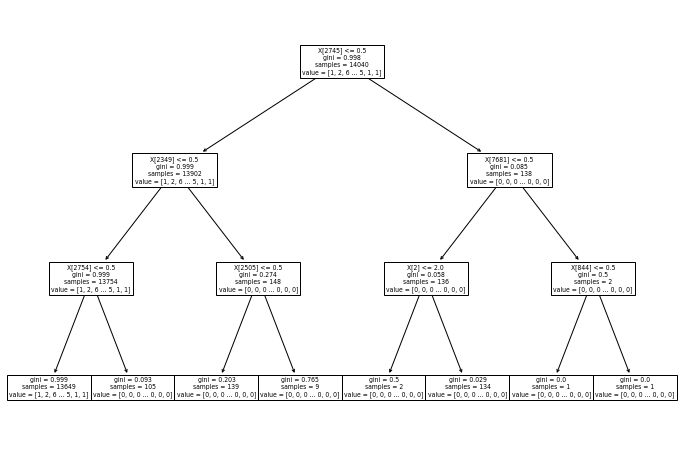

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(classifier.fit(X_train, y_train)) 

Testing Elo Differences

In [34]:
df = pd.read_csv("chess.csv")
df1 = pd.read_csv("legalMoves.csv")

In [ ]:
df = df.rename(columns={"turns": "Turns"})

In [37]:
avg = 0
diff = 0
maxDiff = 0
for x,y in zip(df["White_Rating"], df["Black_Rating"]):
    diff = 0
    diff = x-y
    diff = abs(diff)
    if diff > maxDiff:
        maxDiff = diff
    avg = avg + diff
avg = avg/len(df["White_Rating"])
print("The average difference in ratings is: " + str(avg))
print("The highest difference between elo ratings was: " + str(maxDiff))

The average difference in ratings is: 173.091434838967
The highest difference between elo ratings was: 1605


Highest elo difference is 1605. Average is 173.09

In [39]:
avg = 0
diff = 0
highDiff = 0
eloDiff = []
for x,y in zip(df["White_Rating"], df["Black_Rating"]):
    diff = 0
    diff = x-y
    diff = abs(diff)
    if diff > highDiff:
        highDiff = diff
    avg = avg + diff
    eloDiff.append(diff)
avg = avg/len(df["White_Rating"])
df1["Elo_Diff"] = eloDiff
df["Elo_Diff"] = eloDiff
print(avg)
print(highDiff)

173.091434838967
1605


In [41]:
df1.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,Legal_Moves,Elo_Diff
0,13,0,1,15+2,0.373695,0.207859,"['d4', 'd5', 'c4', 'c6', 'cxd5', 'e6', 'dxe6',...","['d4', 'c4', 'cxd5', 'dxe6', 'Nf3', 'Nc3', 'Bf4']","['d5', 'c6', 'e6', 'fxe6', 'Bb4+', 'Ba5']",['Bf4'],"['Ng5', ' Ne5', ' Nh4', ' Nd2', ' Ng1', ' Rg1'...",309
1,16,1,0,5+10,0.280793,0.244054,"['d4', 'Nc6', 'e4', 'e5', 'f4', 'f6', 'dxe5', ...","['d4', 'e4', 'f4', 'dxe5', 'fxe5', 'Qd4', 'Qe5...","['Nc6', 'e5', 'f6', 'fxe5', 'Nxe5', 'Nc6', 'Nx...",['Bb4+'],"['Ne7', ' Nh6', ' Nf6', ' Be7', ' Bd6', ' Bc5'...",61
2,61,3,1,5+10,0.371608,0.367632,"['e4', 'e5', 'd3', 'd6', 'Be3', 'c6', 'Be2', '...","['e4', 'd3', 'Be3', 'Be2', 'Nd2', 'a4', 'axb5'...","['e5', 'd6', 'c6', 'b5', 'a5', 'c5', 'Nc6', 'R...",['Bd1#'],"['Rh8', ' Rh7', ' Rg6', ' Rf6', ' Re6', ' Rd6'...",4
3,61,3,1,20+0,0.341858,0.343847,"['d4', 'd5', 'Nf3', 'Bf5', 'Nc3', 'Nf6', 'Bf4'...","['d4', 'Nf3', 'Nc3', 'Bf4', 'e3', 'Be2', 'O-O'...","['d5', 'Bf5', 'Nf6', 'Ng4', 'Nc6', 'Qd7', 'O-O...",['Qxg7#'],"['Ra8', ' Rxg7', ' Rf7', ' Re7', ' Rd7', ' Rc7...",15
4,95,3,1,30+3,0.385699,0.351603,"['e4', 'e5', 'Nf3', 'd6', 'd4', 'Nc6', 'd5', '...","['e4', 'Nf3', 'd4', 'd5', 'a3', 'Nc3', 'b4', '...","['e5', 'd6', 'Nc6', 'Nb4', 'Na6', 'Be7', 'Nf6'...",['Rh7#'],"['Qh8+', ' Qf8+', ' Qe8', ' Qd8', ' Qc8', ' Qb...",54


In [31]:
df.drop(df[df["Elo_Diff"] > 500].index, inplace = True)

In [32]:
avg = 0
diff = 0
maxDiff = 0
for x,y in zip(df["White_Rating"], df["Black_Rating"]):
    diff = 0
    diff = x-y
    diff = abs(diff)
    if diff > maxDiff:
        maxDiff = diff
    avg = avg + diff
avg = avg/len(df["White_Rating"])
print(avg)
print(maxDiff)

140.07437928651177
500


In [42]:
df1.to_csv('legalMoves.csv', index=False)

In [3]:
df = pd.read_csv("legalMoves.csv")

In [5]:
df.drop(df[df["Elo_Diff"] > 500].index, inplace = True)
df.reset_index(inplace=True)

In [6]:
df.shape

(18809, 13)

In [7]:
df.tail(60)

,index,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,Legal_Moves,Elo_Diff
18749,19996,60,1,0,5+5,0.624217,0.634953,"[f4, d5, Nf3, Nf6, e3, g6, b3, Bg7, Bb2, O-O, ...","[f4, Nf3, e3, b3, Bb2, Nc3, Bd3, O-O, Ne2, c4,...","[d5, Nf6, g6, Bg7, O-O, c5, Nc6, a6, b5, dxc4,...",['Rxf6'],"[Rfe8, Rd8, Rc8, Rb8, Bb7, Bc6, Bd5, Bxe4, Ree...",37
18750,19997,63,0,1,5+5,0.639875,0.512927,"[d4, Nf6, Nf3, g6, g3, Bg7, Bg2, d6, O-O, O-O,...","[d4, Nf3, g3, Bg2, O-O, Nc3, e4, Nxd4, Ndb5, N...","[Nf6, g6, Bg7, d6, O-O, c5, cxd4, e5, Ne8, a6,...",['Qxc4'],"[Qe8, Qc8, Qa8, Qd7, Qc7, Qb7, Qxf6, Qe6, Qd6,...",229
18751,19998,87,0,1,5+5,0.633612,0.584798,"[d4, Nf6, Nf3, d5, c4, e6, Nc3, Bb4, Bg5, h6, ...","[d4, Nf3, c4, Nc3, Bg5, Bxf6, e3, cxd5, Bb5, O...","[Nf6, d5, e6, Bb4, h6, Qxf6, Nc6, exd5, O-O, B...",['Rc8+'],"[Rc8+, Rd7, Rb7, Rxa7, Rc6, Rc5, Rc4, Rc3, Rcc...",78
18752,19999,50,1,0,7+2,0.469729,0.622544,"[d4, d5, Nf3, Nf6, Bf4, Bf5, e3, c6, Nbd2, e6,...","[d4, Nf3, Bf4, e3, Nbd2, Nh4, Bg5, Nxe4, Be2, ...","[d5, Nf6, Bf5, c6, e6, Be4, Be7, dxe4, Qa5+, Q...",['Qc1+'],"[Kh8, Re8, Rd8, Rc8, Rb8, Ra8, Qg6, Qh5, Qg5, ...",309
18753,20000,29,1,1,7+2,0.628914,0.446743,"[d4, d5, c4, c6, Nc3, dxc4, a4, Bf5, e3, e6, B...","[d4, c4, Nc3, a4, e3, Bxc4, Nf3, O-O, bxc3, Qb...","[d5, c6, dxc4, Bf5, e6, Nf6, Bb4, Bxc3, Ne4, N...",['Qxf7+'],"[Qc8, Qxb8, Qxa8, Qxf7+, Qe7, Qd7, Qc7, Qxa7, ...",336
18754,20001,46,3,0,7+2,0.550104,0.615305,"[e4, d6, d4, Nf6, Nc3, g6, f4, Bg7, Nf3, c5, e...","[e4, d4, Nc3, f4, Nf3, e5, exd6, dxc5, dxe7, B...","[d6, Nf6, g6, Bg7, c5, Nfd7, O-O, Nxc5, Qxe7+,...",['Rb1#'],"[Kh8, Kf8, Kg7, Rf8, Re8, Rd8, Rc8, Rb8, Nd8, ...",141
18755,20002,41,3,1,7+2,0.620042,0.480352,"[d4, d5, c4, c6, Nc3, e6, cxd5, cxd5, Nf3, f5,...","[d4, c4, Nc3, cxd5, Nf3, Bf4, e3, Bb5+, Ne5, d...","[d5, c6, e6, cxd5, f5, Nf6, Bd6, Nc6, Bxe5, Ne...",['Rd8#'],"[Qf8+, Qxh7, Qg7, Qxg6, Qh5, Qh4, Qh3, Bd8, Be...",254
18756,20003,103,2,2,30+30,0.782359,0.811272,"[e4, c5, Nc3, e6, f4, d5, Nf3, dxe4, Nxe4, Nc6...","[e4, Nc3, f4, Nf3, Nxe4, b3, Bd3, Bb2, O-O, Nx...","[c5, e6, d5, dxe4, Nc6, Nf6, Be7, Bd7, Nb4, gx...",['Kg5'],"[Rh5, Rg5, Re5, Rd5+, Rc5, Rb5, Ra5, Kg5, Kg4,...",75
18757,20004,109,2,2,30+30,0.746347,0.774043,"[f4, d5, Nf3, Nf6, e3, g6, Be2, Bg7, O-O, O-O,...","[f4, Nf3, e3, Be2, O-O, b3, Ne5, Nd3, Bb2, Bf3...","[d5, Nf6, g6, Bg7, O-O, Ne4, f6, e5, Nc6, Bf5,...",['Ke2'],"[Kf2, Ke2]",72
18758,20005,92,1,0,45+45,0.755741,0.766805,"[e4, e5, Nf3, Nc6, Bc4, Nf6, d3, Bc5, O-O, d6,...","[e4, Nf3, Bc4, d3, O-O, c3, a4, Na3, Bb5, Bg5,...","[e5, Nc6, Nf6, Bc5, d6, a5, O-O, Be6, Ne7, Ng6...",['Kb4'],"[Kd5, Kc5, Kd4, Kb4, h5, f5, e4, b2]",40


In [17]:
clfRf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=200, min_samples_leaf = 5, oob_score=True)
clfRf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [18]:
# checking the oob score
clfRf.oob_score_

0.27905210390399515

Removing games with high elo differences made minimal or no change

## Adding Bitboard Representation Feature

In [1]:
df = pd.read_csv("legalMoves.csv")

NameError: name 'pd' is not defined

In [25]:
board = chess.Board()

In [26]:
fen = board.fen()

In [18]:
fen

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

In [19]:
board.occupied

18446462598732906495

In [29]:
pos = board.occupied
pos

18446462598732906495

In [30]:
pos = bin(pos)
pos

'0b1111111111111111000000000000000000000000000000001111111111111111'

In [31]:
pos = pos[2:]
pos

'1111111111111111000000000000000000000000000000001111111111111111'

In [11]:
moves = df["Moves"][0]
moves

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

In [12]:
moves = df["Moves"].apply(lambda x: x[:-1])

In [14]:
move = moves[0]

In [42]:
board = chess.Board()
for x in move:
    board.push_san(x)
pos = board.occupied
pos = bin(pos)
pos = pos[2:]

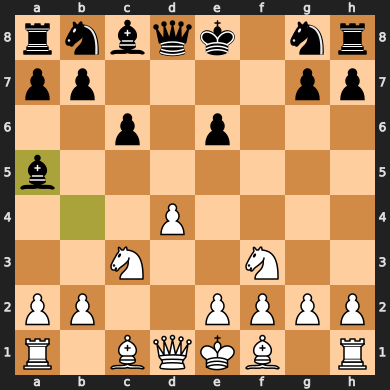

In [43]:
board

In [44]:
pos

'1101111111000011000101000000000100001000001001001111001110111101'

starts at h8, reads along the 8th rank right to left, then starts again on the 7th rank

In [48]:
X = df["Moves"].apply(lambda x: x[:-1])
bitboardsTop = []
bitboardsBottom = []
pos = ""
for x in X:
    board = chess.Board()
    for moves in x:
        board.push_san(moves)
    pos = bin(board.occupied)[2:]
    if len(pos) < 64:
        difference = 64-len(pos)
        for y in range(difference):
            pos = "0" + pos
    bitboardsTop.append(pos[:32])
    bitboardsBottom.append(pos[32:])
df["BitboardTop"] = bitboardsTop
df["BitboardBottom"] = bitboardsBottom

In [31]:
df.head()

,Turns,Outcome,Winner,Time_Control,White_Rating,Black_Rating,Moves,White_Moves,Black_Moves,Final_Move,Legal_Moves,Elo_Diff,Bitboard,BitboardTop,BitboardBottom
0,13,0,1,15+2,0.373695,0.207859,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...","[d4, c4, cxd5, dxe6, Nf3, Nc3, Bf4]","[d5, c6, e6, fxe6, Bb4+, Ba5]",['Bf4'],"[Ng5, Ne5, Nh4, Nd2, Ng1, Rg1, Kd2, Qa4, Qd3, ...",309,1101111111000011000101000000000100001000001001...,11011111110000110001010000000001,00001000001001001111001110111101
1,16,1,0,5+10,0.280793,0.244054,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...","[d4, e4, f4, dxe5, fxe5, Qd4, Qe5+, c4]","[Nc6, e5, f6, fxe5, Nxe5, Nc6, Nxe5, Bb4+]",['Bb4+'],"[Ne7, Nh6, Nf6, Be7, Bd6, Bc5, Bb4+, Ba3, Kf7,...",61,1111110111001111000000000001000000010100000000...,11111101110011110000000000010000,00010100000000001100001111110111
2,61,3,1,5+10,0.371608,0.367632,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...","[e4, d3, Be3, Be2, Nd2, a4, axb5, bxc6, Nc4, c...","[e5, d6, c6, b5, a5, c5, Nc6, Ra6, a4, a3, Rxa...",['Bd1#'],"[Rh8, Rh7, Rg6, Rf6, Re6, Rd6, Rh5, Rh4, Rh3, ...",4,1000001000010000010000010001010000010011100010...,10000010000100000100000100010100,0001001110001011010000
3,61,3,1,20+0,0.341858,0.343847,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...","[d4, Nf3, Nc3, Bf4, e3, Be2, O-O, Nb5, Rc1, Ra...","[d5, Bf5, Nf6, Ng4, Nc6, Qd7, O-O-O, Nb4, Nxa2...",['Qxg7#'],"[Ra8, Rxg7, Rf7, Re7, Rd7, Rc7, Rb7, Ra6, Ra5,...",15,1000000011000001111001000101100000000000010100...,10000000110000011110010001011000,00000000010100001011001001100000
4,95,3,1,30+3,0.385699,0.351603,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...","[e4, Nf3, d4, d5, a3, Nc3, b4, Bg5, b5, Bxf6, ...","[e5, d6, Nc6, Nb4, Na6, Be7, Nf6, O-O, Nc5, Bx...",['Rh7#'],"[Qh8+, Qf8+, Qe8, Qd8, Qc8, Qb8, Qa8, Qh7+, Qg...",54,1000000001000001000000000000000000100010010000...,10000000010000010000000000000000,0010001001000001100000000000000


In [54]:
df.to_csv('legalMoves.csv', index=False)

In [57]:
df = pd.read_csv("legalMoves.csv")

In [41]:
df.dtypes

Turns               int64
Outcome             int64
Winner              int64
Time_Control       object
White_Rating      float64
Black_Rating      float64
Moves              object
White_Moves        object
Black_Moves        object
Final_Move         object
Legal_Moves        object
Elo_Diff            int64
Bitboard           object
BitboardTop        object
BitboardBottom     object
dtype: object

In [57]:
df["BitboardTop"][0]

1.101111111000011e+31

In [61]:
df["BitboardBottom"][2]

'0001001110001011010000'

In [59]:
df = df.astype({'BitboardTop':'bin'})

TypeError: data type 'bin' not understood

In [60]:
df['BitboardBottom'] = df['BitboardBottom'].apply(lambda x: int(x, 2))

ValueError: invalid literal for int() with base 2: ''

In [33]:
#Concatting Elo of White and Black player into features
X = pd.concat([df[["BitboardTop", "BitboardBottom"]],X], axis=1)

In [38]:
X

,BitboardTop,BitboardBottom,Moves
0,11011111110000110001010000000001,00001000001001001111001110111101,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb..."
1,11111101110011110000000000010000,00010100000000001100001111110111,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx..."
2,10000010000100000100000100010100,0001001110001011010000,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4..."
3,10000000110000011110010001011000,00000000010100001011001001100000,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6..."
4,10000000010000010000000000000000,0010001001000001100000000000000,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N..."
...,...,...,...
20053,10101011000101110111101000000000,00011000000001001110011101011101,"[d4, f5, e3, e6, Nf3, Nf6, Nc3, b6, Be2, Bb7, ..."
20054,10011000000100001010001001101000,00000000000100000000000000,"[d4, d6, Bf4, e5, Bg3, Nf6, e3, exd4, exd4, d5..."
20055,11010100111101111100100100100000,101000000101001110001110010001,"[d4, d5, Bf4, Nc6, e3, Nf6, c3, e6, Nf3, Be7, ..."
20056,10110000000000000001100000000000,010000010000000000,"[e4, d6, d4, Nf6, e5, dxe5, dxe5, Qxd1+, Kxd1,..."


In [34]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=23) # 70%/30% testing/training

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
clfRf = RandomForestClassifier(random_state=23, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [37]:
clfRf.fit(X_train, y_train)

ValueError: could not convert string to float: ''

In [ ]:
# checking the oob score
clfRf.oob_score_

# References

https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/<br>
https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/ <br>
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/<br>
https://practicaldatascience.co.uk/machine-learning/how-to-save-and-load-machine-learning-models-using-pickle<br>
https://www.youtube.com/watch?v=n5vV4u-nKtw<br>
^ Bitboards